# Исследование лояльности пользователей

# Задача

Для запуска программы лояльности необходимо определить лояльных пользователей и назначить им определенные условия. Данные для анализа представляют собой логи по покупкам пользователей.

In [133]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Предподготовка данных

Мы загрузили данные из файла и выбрали необходимые колонки, а также извлекли информацию о бренде из строки описания товара.

In [136]:
file_path = 'C:/Users/elina/Notebooks/lesson_3_data_1_.csv'
df = pd.read_csv(file_path, encoding='windows-1251')

In [138]:
df.head()

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


Таблица содержит множество разнообразных данных, из которых для исследования нужены ид пользователя и данные о покупке. Отберем эту информацию в отдельный датасет и переименуем колонки: ид пользователя и информация о бренде соответственно.

In [141]:
user_df = df[['tc', 'art_sp']]
user_df

,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2
...,...,...
48124,45518841,FIDEOS 0 500 G Brand_4
48125,110824211,PLUMAS 3 500 G Brand_4
48126,1408670389,MACARRONES 500 G Store_Brand
48127,1408670389,SPAGHETTI 500 G Store_Brand


In [143]:
user_df = user_df.rename(columns={'tc': 'user_id', 'art_sp': 'brand_info'})

In [145]:
user_df.head()

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


Создадим новую колонку для фиксации названия бренда из информации о покупках и заполним ее (послднее слово из колонки информация о бренде).

In [148]:
user_df['brand_name'] = user_df.brand_info.apply(lambda x: x.split(' ')[-1])

In [150]:
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


# Трансформация колонок, создание новых метрик

Рассчитаем следующие метрики для каждого пользователя:

- Общее количество покупок
- Количество уникальных брендов
- Любимый бренд (бренд с наибольшим количеством покупок).

## Общее количество покупок на пользователя
для оценки целесообразности включения его в выборку лояльных пользователей

In [154]:
 user_df \
    .groupby('user_id', as_index=False) \
    .agg({'brand_name': 'count'}) \
    .rename(columns={'brand_name': 'purchases'}) \
    .describe()

,user_id,purchases
count,1.176400e+04,11764.000000
mean,7.690517e+07,4.091210
std,1.622210e+08,4.573143
min,-1.236395e+09,1.000000
25%,1.503761e+07,1.000000
50%,4.682179e+07,2.000000
75%,9.311601e+07,5.000000
max,1.408849e+09,60.000000


25 процентов пользователей совершили 5 и более покупок - можно считать их лояльными пользователями для старта исследования, отбросим пользователей с меньшим количеством покупок:

In [157]:
users_purchases = user_df \
    .groupby('user_id', as_index=False) \
    .agg({'brand_name': 'count'}) \
    .rename(columns={'brand_name': 'purchases'}) \
    .query('purchases >= 5')
users_purchases

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5
...,...,...
11740,1408767189,5
11750,1408783189,10
11751,1408783379,6
11754,1408798879,8


## Количество уникальных брендов
Для кажд пользователя определили количество уникальных брендов. 
Логика выбора брендов: 
- группировка по ид пользователя
- аггрегация по имени бренда для каждого ползователя, при этом берем список уникальных брендов для каждого ид
- переименование.


In [160]:
users_unique_brands = user_df \
    .groupby('user_id', as_index=False) \
    .agg({'brand_name': pd.Series.nunique}) \
    .rename(columns={'brand_name': 'unique_brands'})
users_unique_brands

,user_id,unique_brands
0,-1236394515,1
1,1031,2
2,4241,2
3,17311,1
4,17312,2
...,...,...
11759,1408817589,2
11760,1408825059,1
11761,1408832719,1
11762,1408840919,1


## Любимый бренд

Далее для каждого пользователя определили бренд с наибольшим количеством покупок - любимый бренд.
Логика отбора:
- группировка по ид пользователя и имени бренда
- аггрегация по количеству строк, при этом считаем по колонке, не участвующей в группировке
- сортируем значения по ид опльзователя и имени бренда по убыванию (сначала идет бренд с макс количеством покупок)
- для каждого пользователя теперь нужно взять только 1 строку - с максимальным количеством покупок, для этого снова группирует и берем первую строчку в этой группе
- переименование полученных колонок  в любимый бренд и количество покупок по нему.

In [170]:
lovely_brand_purchases = user_df \
    .groupby(['user_id', 'brand_name'], as_index=False) \
    .agg({'brand_info': 'count'}) \
    .sort_values(['user_id', 'brand_info'], ascending=[False, False]) \
    .groupby('user_id') \
    .head(1) \
    .rename(columns={'brand_name': 'lovely_brand', 'brand_info': 'lovely_brand_purchases'})
lovely_brand_purchases

,user_id,lovely_brand,lovely_brand_purchases
18187,1408849249,Store_Brand,1
18186,1408840919,Store_Brand,1
18185,1408832719,Brand_4,3
18184,1408825059,Brand_1,1
18183,1408817589,Store_Brand,2
...,...,...,...
6,17312,Brand_1,1
5,17311,Brand_4,2
3,4241,Brand_4,3
2,1031,Store_Brand,5


# Исследование лояльности пользователей

Лояльными считаются пользователи, которые покупали максимальное количество товаров одного бренда.

Соберем в одну таблицу все данные: количество покупок пользователей, количество уникальных брендов и информацию по бренду с наибольшим количеством покупок (любимый бренд: название и количество).


In [173]:
loyalty_df = users_purchases \
    .merge(users_unique_brands, on='user_id') \
    .merge(lovely_brand_purchases, on='user_id')
loyalty_df

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,25971,7,2,Store_Brand,5
3,40911,27,5,Brand_4,19
4,45181,5,4,Store_Brand,2
...,...,...,...,...,...
3378,1408767189,5,1,Brand_4,5
3379,1408783189,10,2,Store_Brand,8
3380,1408783379,6,2,Brand_1,4
3381,1408798879,8,3,Store_Brand,4


## Лояльные пользователи

Есть некоторое количество пользователей, которые покупали товары только одного бренда, то есть количество покупок равно количеству покупок любимого бренда, а число уникальных брендов равно 1. Очевидно, что этих попользователей можно считать лояльными к таким брендам.
Выделим их в отдельную группу лояльных пользователей.

In [189]:
loyal_users = loyalty_df[loyalty_df.unique_brands == 1].sort_values('purchases', ascending=False)
loyal_users

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
1315,19317282,55,1,Brand_4,55
1652,27291281,36,1,Brand_4,36
1407,20835112,27,1,Brand_4,27
2330,72232811,25,1,Brand_4,25
1937,38450591,24,1,Brand_4,24
...,...,...,...,...,...
1853,32606341,5,1,Store_Brand,5
1839,32015911,5,1,Brand_4,5
1794,30403191,5,1,Brand_4,5
1789,30354881,5,1,Brand_4,5


Выявлено 911 лояльных хпользователей, которые покупали товары только одного бренда.

## Распределение уровня лояльности

In [292]:
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases
loyalty_df

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,25971,7,2,Store_Brand,5,0.714286
3,40911,27,5,Brand_4,19,0.703704
4,45181,5,4,Store_Brand,2,0.400000
...,...,...,...,...,...,...
3378,1408767189,5,1,Brand_4,5,1.000000
3379,1408783189,10,2,Store_Brand,8,0.800000
3380,1408783379,6,2,Brand_1,4,0.666667
3381,1408798879,8,3,Store_Brand,4,0.500000


In [231]:
loyalty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3383 entries, 0 to 3382
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 3383 non-null   int64  
 1   purchases               3383 non-null   int64  
 2   unique_brands           3383 non-null   int64  
 3   lovely_brand            3383 non-null   object 
 4   lovely_brand_purchases  3383 non-null   int64  
 5   loyalty_score           3383 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 158.7+ KB


## Визуализация

Отобразим распределение уровня лояльности пользователей на графике

D:\soft\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


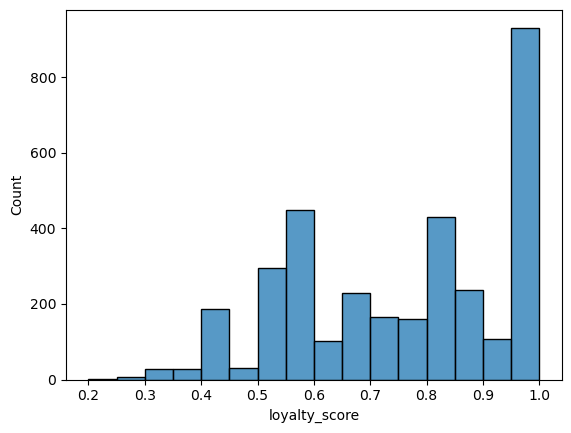

In [257]:
ax = sns.histplot(loyalty_df.loyalty_score)

Данные на графике распределения уровня лояльности смещены вправо, что говорит о преобладании лояльных пользователей среди всех покупателей. 
При этом эмпирическая граница скор балла зависит от задачи: для массовой акции можно установить значение 0.7, для узкой задачи - 1.

Отобразим количество лояльных пользоватеелй по различным брендам.
Для этого сгруппируем данные по брендам, для каждого бренда укажем медианное значение скор балла и количество пользователей, для которых этот бренд является любимым.

In [296]:
brands_loyalty = loyalty_df \
    .groupby('lovely_brand', as_index=False) \
    .agg({'loyalty_score': 'median', 'user_id': 'count'}) \
    .rename(columns={'user_id': 'users', 'loyalty_score': 'median_loyalty_score'})
brands_loyalty

,lovely_brand,median_loyalty_score,users
0,Brand_1,0.679487,410
1,Brand_2,0.600000,88
2,Brand_3,0.500000,115
3,Brand_4,0.818182,2041
4,Brand_5,0.600000,5
5,Brand_7,0.444444,9
6,Store_Brand,0.750000,715


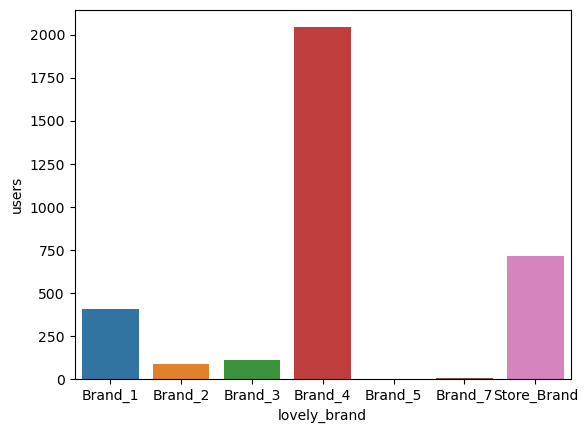

In [268]:
ax = sns.barplot(data=brands_loyalty, x='lovely_brand', y='users')

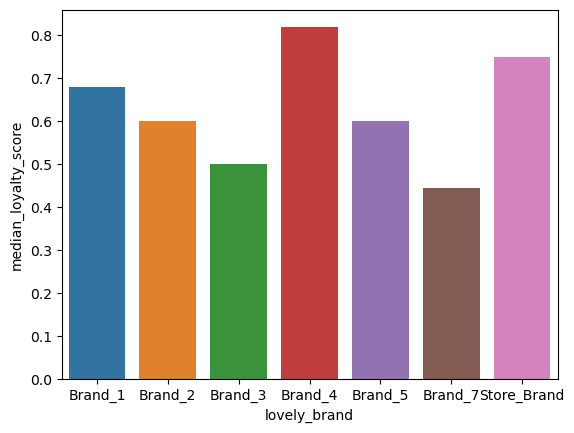

In [272]:
ax = sns.barplot(data=brands_loyalty, x='lovely_brand', y='median_loyalty_score')

# Выводы

1. Распределение уровня лояльности пользователей
   
На графике распределения уровня лояльности пользователей видно, что большинство пользователей имеет высокий уровень лояльности, с преобладанием значений ближе к 1. При этом 911 пользователей имеют максимальный уровень лояльности к одному из брендов. Это означает, что многие пользователи предпочитают один конкретный бренд, что свидетельствует о высокой степени лояльности к этому бренду.

3. Количество лояльных пользователей по брендам
   
Наибольшее количество лояльных пользователей оказалось у Brand_4 (2041 пользователей), за ним следует Store_Brand (715 пользователей) и Brand_1 (410 пользователей).

5. Медианный уровень лояльности по брендам
   
Brand_4 также показал самый высокий медианный уровень лояльности (0.818), далее идут Store_Brand (0.750) и Brand_1 (0.679).


### Рекомендации
1. Поддержка и развитие ведущих брендов:

Рекомендуется поддерживать и развивать Brand_4 и Store_Brand, так как они имеют наибольшее количество лояльных пользователей.

2. Анализ факторов лояльности:

Провести анализ факторов, влияющих на высокую лояльность к Brand_4 и Store_Brand, чтобы применять успешные стратегии к другим брендам.

3. Работа с менее популярными брендами:

Разработать стратегии повышения лояльности для брендов с меньшим количеством лояльных пользователей, такие как Brand_2 и Brand_3.

4. Целевые маркетинговые кампании:

Разрабатывать кампании, направленные на поддержание и увеличение лояльности, основываясь на анализе медианного уровня лояльности.